In [1]:
import torch


import math
import random


def n_points(r, n, offset, randomness=0.0):
    for i in range(n):
        if randomness > 0:
            theta = (2 * math.pi * i / n + offset) * (
                1 + randomness * (random.random() - 0.5) * 2
            )
            r = r * (1 + randomness * (random.random() - 0.5) * 2)
        else:
            theta = 2 * math.pi * i / n + offset

        yield (r * math.cos(theta), r * math.sin(theta))


#


def vector_field(z, t, num_points, radius=0.5):
    score = torch.zeros_like(z)

    if z.norm() > radius + 0.1:
        nearest_neighbors = []
        for x, y in n_points(radius, num_points, math.pi / num_points):
            dist_vec = torch.tensor([x, y]) - z
            dist = dist_vec.norm()
            nearest_neighbors.append((dist, dist_vec))

        sorted_neighbors = sorted(nearest_neighbors, key=lambda x: x[0])
        score += sorted_neighbors[0][1]

    else:
        for x, y in n_points(radius / 2, num_points, 0):
            dist_vec = torch.tensor([x, y]) - z
            dist = dist_vec.norm()
            score += dist_vec / dist.pow(2.0)

    return score / score.norm()

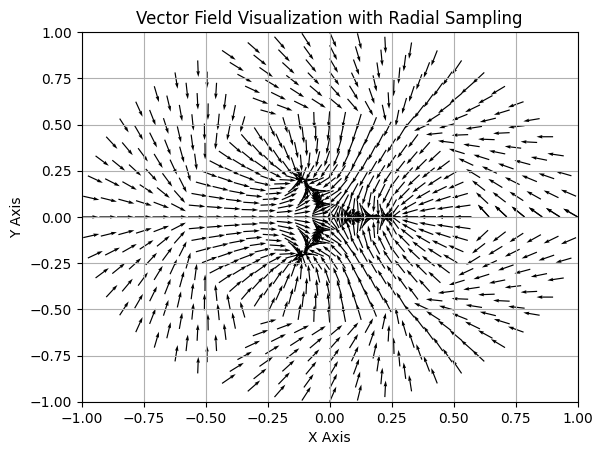

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Create points radially
radii = np.linspace(0, 1, 15)  # You can adjust the number of points as needed
angles = np.linspace(0, 2 * np.pi, 57)
R, A = np.meshgrid(radii, angles)
X = R * np.cos(A)
Y = R * np.sin(A)

U = np.zeros_like(X)
V = np.zeros_like(Y)

# Compute the vector field at each point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
        t = 0  # You can change the value of t as needed
        field = vector_field(z, t, 3)
        U[i, j] = field[0]
        V[i, j] = field[1]

# Plot the vector field using quiver
plt.quiver(X, Y, U, V, scale=30)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Vector Field Visualization with Radial Sampling")
plt.grid(True)
plt.show()

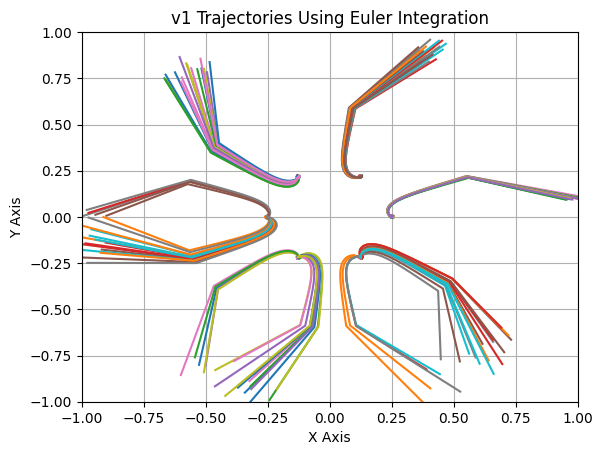

In [10]:
# Euler integration method for ODE
def euler_integration(z0, t0, tf, dt, num_points, fn):
    z = z0
    t = t0
    trajectory = [z0.numpy()]

    while t < tf:
        dz = fn(z, t)
        z = z + dz * dt
        trajectory.append(z.numpy())
        t += dt

    return np.array(trajectory)


initial_positions = []
end_positions = []

n_iteration = 20


for _ in range(n_iteration):
    initial_positions.extend(list(n_points(1, 6, 0.1, 0.05)))

# Parameters for Euler integration
t0 = 0
tf = 1
dt = 0.01
num_points = 6  # Adjust as needed

# Plot the trajectories for each initial position
for position in initial_positions:
    z0 = torch.tensor(position, dtype=torch.float32)
    trajectory = euler_integration(
        z0, t0, tf, dt, num_points, fn=lambda z, t: vector_field(z, t, num_points)
    )
    end_point = trajectory[-1]
    end_positions.append(end_point.tolist())

    plt.plot(trajectory[:, 0], trajectory[:, 1])


# Customize the plot
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("v1 Trajectories Using Euler Integration")
plt.grid(True)
plt.show()

In [4]:
import torch.nn as nn


class VectorFieldMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()

    def forward(self, z, t):
        x = self.relu(self.linear1(z))
        x = self.linear2(x)
        return x


v1 = VectorFieldMLP(32)

In [5]:
initial_positions_pt = torch.tensor(initial_positions, dtype=torch.float32)
end_positions_pt = torch.tensor(end_positions, dtype=torch.float32)

dataloader = torch.utils.data.DataLoader(
    list(zip(initial_positions_pt, end_positions_pt)), batch_size=64, shuffle=True
)

In [11]:
from torch.optim import Adam

optimizer = Adam(v1.parameters(), lr=1e-3)

for epoch in range(100):
    for x0, x1 in dataloader:
        optimizer.zero_grad()
        t = torch.rand_like(x0[:, 0:1])

        mid = x1 * t + x0 * (1 - t)

        loss = (x1 - x0 - v1(mid, t)).pow(2).sum()

        loss.backward()
        optimizer.step()

        print(loss.item())

3.9397921562194824
4.753078937530518
5.048866271972656
4.008481979370117
3.4100494384765625
4.236238956451416
4.59234094619751
4.104795932769775
5.1905388832092285
3.255887269973755
3.814271926879883
3.8399529457092285
3.9037365913391113
3.8387341499328613
3.627917528152466
2.7405052185058594
4.093716144561768
4.454775810241699
4.712060451507568
3.7717597484588623
3.2913124561309814
3.861992359161377
3.873838424682617
3.268706798553467
3.273836135864258
3.298616886138916
3.7704336643218994
2.902390241622925
3.7249302864074707
2.6199028491973877
3.4464688301086426
3.1723201274871826
4.326704502105713
2.770022392272949
3.1310083866119385
2.7532095909118652
4.174112319946289
3.143831491470337
3.1066184043884277
3.0681562423706055
3.883625030517578
2.6843690872192383
3.093121290206909
3.385927438735962
2.7930550575256348
2.66877818107605
2.783627986907959
2.912306785583496
2.910416841506958
2.8352839946746826
3.564136505126953
2.4165313243865967
3.1615867614746094
3.76898455619812
3.868845

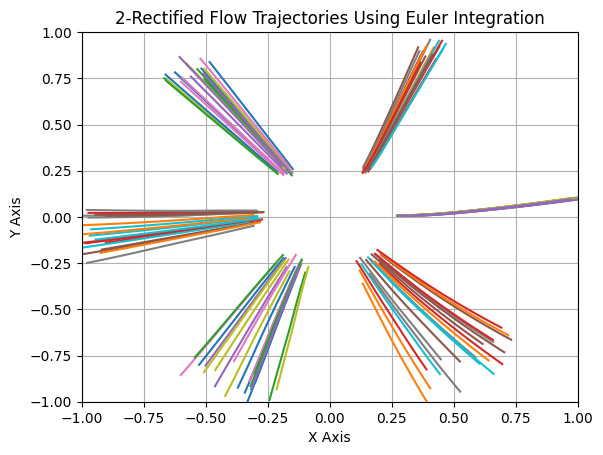

In [12]:
# Now sample from the 1-Rectified Velocity Field, v1


end_positions = []

n_iteration = 20



# Parameters for Euler integration
t0 = 0
tf = 1
dt = 0.01
num_points = 6  # Adjust as needed

# Plot the trajectories for each initial position
with torch.no_grad():
    for position in initial_positions:
        z0 = torch.tensor(position, dtype=torch.float32)
        trajectory = euler_integration(
            z0, t0, tf, dt, num_points, fn=lambda z, t: v1(z, t)
        )
        end_point = trajectory[-1]
        end_positions.append(end_point.tolist())

        plt.plot(trajectory[:, 0], trajectory[:, 1])


# Customize the plot
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("2-Rectified Flow Trajectories Using Euler Integration")
plt.grid(True)
plt.show()